# Born to slide: mobile origin licensing factors confer resistance to transcription conflicts

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ 6H
+ S6E

#### Archives:
+ Transcription_ORC-DNA_T7T_ATP.yama
+ Transcription_licensed-DNA_T7T_ATP.yama
+ Transcription_licensed-DNA_T7T_ATPgS.yama

#### Additional data:
+ none

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
from marspy.convert.archive import DnaMoleculeArchive, instantiate_archive, describe_archives
from tqdm.notebook import tqdm
from functools import reduce

marspy initialized.


### Select archives

In [3]:
selected_archives = ['Transcription_ORC-DNA_T7T_ATP.yama',
                     'Transcription_licensed-DNA_T7T_ATP.yama',
                     'Transcription_licensed-DNA_T7T_ATPgS.yama']

### Figure style and output directory

In [4]:
from figure_style import *

In [5]:
set_style_paper()

In [6]:
dir_out = '/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure6/'
dir_out

'/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure6/'

### Instantiate selected archives

In [7]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

### Archives Overview

In [8]:
describe_archives(DnaMoleculeArchive.instances)

,# of datasets,# of molecules,labeled proteins,nucleotide,HS challenge?,chromatin,terminator?,archive validation
Transcription_ORC-DNA_T7T_ATP,3,612,SORT-LD555-ORC; ybbR-LD655-T7,ATP,False,n/a,True,passed
Transcription_licensed-DNA_T7T_ATP,2,653,SNAP-AF488-T7; SORT-LD555-ORC; ybbR-LD655-MCM,ATP,False,n/a,True,passed
Transcription_licensed-DNA_T7T_ATPgS,2,482,SNAP-AF488-T7; SORT-LD555-ORC; ybbR-LD655-MCM,ATPgS,False,n/a,True,passed


### Load segment tables, apply filter & detect pauses

In [9]:
for index,archive in enumerate(tqdm(DnaMoleculeArchive.instances)):
    
    archive.add_segments_tables()
    archive.filter_segments(b_min=-10, sigma_b_max=10)
    archive.detect_pauses()


### Generate main df

In [10]:
def setup_pandas_df(archive_instances):
    '''
    Sets up a multilevel df with all relevant information
    '''
    
    # indices will be UIDs
    prefixes = set()
    for archive in archive_instances:
        prefixes.update(archive.prefixes)
    col_1 = sorted(list(prefixes))
    #inside
    col_2 = ['initial_intensity', 'lifetime', 'start_site', 'stop_site', 'number_pauses']
    col_3 = ['']
    hier_index = pd.MultiIndex.from_product([col_1,col_2,col_3],names=['molecule','properties','properties_details'])

    return pd.DataFrame(columns=hier_index)
    

In [11]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()


Empty DataFrame
Columns: [(MCM_1_, initial_intensity, ), (MCM_1_, lifetime, ), (MCM_1_, number_pauses, ), (MCM_1_, start_site, ), (MCM_1_, stop_site, ), (MCM_2_, initial_intensity, ), (MCM_2_, lifetime, ), (MCM_2_, number_pauses, ), (MCM_2_, start_site, ), (MCM_2_, stop_site, ), (ORC_1_, initial_intensity, ), (ORC_1_, lifetime, ), (ORC_1_, number_pauses, ), (ORC_1_, start_site, ), (ORC_1_, stop_site, ), (ORC_2_, initial_intensity, ), (ORC_2_, lifetime, ), (ORC_2_, number_pauses, ), (ORC_2_, start_site, ), (ORC_2_, stop_site, ), (T7_1_, initial_intensity, ), (T7_1_, lifetime, ), (T7_1_, number_pauses, ), (T7_1_, start_site, ), (T7_1_, stop_site, )]
Index: []

[0 rows x 25 columns]

In [12]:
# fill dataframe
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        #print('handling molecule '+molecule.uid)
        # general columns first
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()
        df.loc[molecule.uid,'dna_count_valid'] = archive.dna_count_valid
        df.loc[molecule.uid,'hs_wash'] = archive.highsalt_wash
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'t7_terminator'] = archive.t7_terminator
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)

        # general proteins
        for protein in molecule.proteins:
            #store protein number
            df.loc[molecule.uid,'number_'+protein] = molecule.params['Number_'+protein]
            #assign label for each protein
            df.loc[molecule.uid,'label_'+protein] = archive.labels[protein]
            
            # burst velocity (weighted average, exclude pauses, all regions)
            # always calculate weighted average for all seg_dfs of a protein
            # check if protein has a SegmentsTable, otherwise skip
            if len(list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))) > 0:
                df.loc[molecule.uid,('velocity_'+protein)] = \
                np.average([seg_df.calc_rate()[0] for seg_df in list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))],
                           weights=[seg_df.calc_rate()[1] for seg_df in list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))])
        
        # every specific protein
        for prefix in molecule.prefixes:

            #take mean intensity from first 5 frames (maybe need try block later if shorter traces)
            df.loc[molecule.uid,(prefix,'initial_intensity')] = molecule.df.iloc[:5][prefix+'Intensity'].mean()

            #lifetime (in frames) defined on tracking length
            df.loc[molecule.uid,(prefix,'lifetime')] = len(molecule.df[prefix+'y'].dropna())
            
            #start & stop site
            if re.match('T7',prefix):
                df.loc[molecule.uid,(prefix,'start_site')] = molecule.df[prefix+'Position_on_DNA'].min()
                df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()
            else:
                df.loc[molecule.uid,(prefix,'start_site')] = molecule.df.iloc[:5][prefix+'Position_on_DNA'].mean()
                df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()
            
            #pauses:
            #number of pauses
            #- do not consider first segment (transcription stalling before UTP arrival)
            #- do not consider pauses above 19 kb on DNA (exclude diffraction limit towards end of DNA = 1.5-2kb)
            #- do not consider pauses with less than 20 seconds (x2-x1)
            
            #note: following is split up in multiple lines to avoid long arguments and reusage
            #save as temporal variable (already exclude exclude first segment of each segment table (index 0 stays in concatenated))
            # check if protein prefix has a SegmentsTable, otherwise skip
            if len(list(filter(lambda seg_df: prefix == seg_df.prefix, molecule.seg_dfs))) > 0:
                _seg_df = pd.concat([seg_df.df for seg_df in list(filter(lambda seg_df: prefix == seg_df.prefix, molecule.seg_dfs))]).drop(0,axis=0)
                # reset index for proper loops by index later
                _seg_df.reset_index(drop=True, inplace=True)
                # filter df based on pause definition (keep all segments which are not a pause for recovery)
                _seg_df = _seg_df[(_seg_df['x2'] - _seg_df['x1'] >= 20) & 
                                  (_seg_df['y2'] < 19000) & (_seg_df['y1'] < 19000) | 
                                  (_seg_df['pause_B'] == False)]
                             
            
                df.loc[molecule.uid,(prefix,'number_pauses')] = _seg_df['pause_B'].sum()
            
                #loop through filtered _seg_df to get pause details:
                pause_counter = 0
                for row in _seg_df.index:
                    #do we have a pause segment?
                    if _seg_df.loc[row,'pause_B']:
                        pause_counter+=1

                        # pause duration (endtime - starttime: x2-x1)
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'duration')] = \
                        _seg_df.loc[row,'x2'] - _seg_df.loc[row,'x1']

                        # pause position on dna (mean of start and end: y2-y1)
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'position_on_dna')] = \
                        (_seg_df.loc[row,'y2'] + _seg_df.loc[row,'y1']) / 2

                        # does it recover from pause (=> is it the last segment)
                        # note: concatenated df is perfect because subsequent region can show pause recovery
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'recovery')] = \
                        row != _seg_df.index.max()

                # sanity check between pause_counter and earlier detected pauses
                # [0] necessary because of multi-index. use .xs() alternatively
                if pause_counter != df.loc[molecule.uid,(prefix,'number_pauses')][0]:
                    print(f"Attention! Problem with pause detection in molecule {molecule.uid}.")           

# fill all NaN values in number_protein with 0
proteins = set()
for archive in DnaMoleculeArchive.instances:
    proteins.update(archive.proteins)

for protein in proteins:
    df['number_'+protein] = df['number_'+protein].apply(lambda value: 0 if np.isnan(value) else value)            
            
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [13]:
df.head()

molecule                          MCM_1_                                  \
properties             initial_intensity lifetime number_pauses  pause_1   
properties_details                                              duration   
pk2dBNneF7XRUuyXZaQrtm               NaN      NaN           NaN      NaN   
mWfx2ecdDME7TVQjKoT9SP               NaN      NaN           NaN      NaN   
wbhZ4dxMGK5zFpzbyuDSPm               NaN      NaN           NaN      NaN   
5uMjLbVZMnnsCqygC56oWH               NaN      NaN           NaN      NaN   
42FUkWDPdubQSZiHYdMdf6               NaN      NaN           NaN      NaN   

molecule                                                                  \
properties                                       pause_2                   
properties_details     position_on_dna recovery duration position_on_dna   
pk2dBNneF7XRUuyXZaQrtm             NaN      NaN      NaN             NaN   
mWfx2ecdDME7TVQjKoT9SP             NaN      NaN      NaN             NaN   
wbhZ4dxMGK5zFpzbyuDSPm             NaN      NaN      NaN             NaN   
5uMjLbVZMnnsCqygC56oWH             NaN      NaN      NaN             NaN   
42FUkWDPdubQSZiHYdMdf6             NaN      NaN      NaN             NaN   

molecule                                    ...    label_T7 nucleotide  \
properties                      start_site  ...                          
properties_details     recovery             ...                          
pk2dBNneF7XRUuyXZaQrtm      NaN        NaN  ...  ybbR-LD655        ATP   
mWfx2ecdDME7TVQjKoT9SP      NaN        NaN  ...  ybbR-LD655        ATP   
wbhZ4dxMGK5zFpzbyuDSPm      NaN        NaN  ...  ybbR-LD655        ATP   
5uMjLbVZMnnsCqygC56oWH      NaN        NaN  ...  ybbR-LD655        ATP   
42FUkWDPdubQSZiHYdMdf6      NaN        NaN  ...  ybbR-LD655        ATP   

molecule               number_MCM number_ORC number_T7 t7_terminator  \
properties                                                             
properties_details                                                     
pk2dBNneF7XRUuyXZaQrtm        0.0        1.0       1.0          True   
mWfx2ecdDME7TVQjKoT9SP        0.0        1.0       1.0          True   
wbhZ4dxMGK5zFpzbyuDSPm        0.0        0.0       1.0          True   
5uMjLbVZMnnsCqygC56oWH        0.0        1.0       1.0          True   
42FUkWDPdubQSZiHYdMdf6        0.0        1.0       1.0          True   

molecule                                                             tags  \
properties                                                                  
properties_details                                                          
pk2dBNneF7XRUuyXZaQrtm  [coll_T7_1_ORC_1_push, T7T_ORC_1_remain, repre...   
mWfx2ecdDME7TVQjKoT9SP  [accept, coll_T7_1_ORC_1_push, T7T_ORC_1_slide...   
wbhZ4dxMGK5zFpzbyuDSPm                                           [accept]   
5uMjLbVZMnnsCqygC56oWH                   [accept, coll_T7_1_ORC_1_bypass]   
42FUkWDPdubQSZiHYdMdf6                   [accept, coll_T7_1_ORC_1_bypass]   

molecule               velocity_MCM velocity_ORC velocity_T7  
properties                                                    
properties_details                                            
pk2dBNneF7XRUuyXZaQrtm          NaN    53.144806   55.150532  
mWfx2ecdDME7TVQjKoT9SP          NaN    68.149332   63.288323  
wbhZ4dxMGK5zFpzbyuDSPm          NaN          NaN   61.306338  
5uMjLbVZMnnsCqygC56oWH          NaN          NaN   59.362366  
42FUkWDPdubQSZiHYdMdf6          NaN          NaN   59.097410  

[5 rows x 55 columns]

## Figures

### Figure 6H: MCM and ORC stability at T7T

In [14]:
def calc_msd(df, prefix, msd_col, time_col, tau=1, start=np.nan, end=np.nan):
    '''
    Calculates mean square displacement of molecules.
    Remove pairs with missing slices in interval, do not drop NaN values!
    *df: dataframe
    *prefix: protein prefix
    *msd_col: column in df to calculate msd (without protein prefix!)
    *time_col: time column in df (without protein prefix!)
    *tau: time delta used to calculate msd (without protein prefix!)
    
    returns (msd, dtime)
    msd: mean squared error
    dtime: mean time difference underlying msd calculation
    '''
    # if not start / end was specified by used, set to max range
    if np.isnan(start):
        start=df[prefix+time_col].iloc[0]
        
    if np.isnan(end):
        end=df[prefix+time_col].iloc[-1]
    
    # will be a more accurate way to calculate MSD due to existing NaN values
    diffs = []
    dtimes = []
    for row in df.index:
            try:
                # check if sliding window range
                if (df.loc[row, prefix+time_col] >= start and df.loc[row+tau, prefix+time_col] <= end):
                    
                    # check if we have consecutive frames (slices) which are not null
                    if (((df.loc[row+tau, prefix+'slice'] - df.loc[row, prefix+'slice']) == tau) and not
                        ((np.isnan(df.loc[row+tau, prefix+msd_col]) or np.isnan(df.loc[row, prefix+msd_col])))):
                        
                        diffs.append(df.loc[row+tau, prefix+msd_col] - df.loc[row, prefix+msd_col])
                        dtimes.append(df.loc[row+tau, prefix+time_col] - df.loc[row, prefix+time_col])

                    else:
                        #skip to next row
                        continue
                
            # end of df
            except KeyError:
                break
            
    return np.mean(np.square(diffs)), np.mean(dtimes)

In [15]:
# df for T7T outcomes - MCM
df_mcm_stab = pd.DataFrame(columns=['mcm_state','t7t_outcome','mcm_intensity','variance (kbp^2)',
                                    'msd (kbp^2)', 'dtime (s)', 'd_coeff (kbp^2/s)'])

# loop through all archives with chromatin low (50x) and high (75x)
for archive in DnaMoleculeArchive.instances:
    
    # which experiment are we looking at?
    
    if 'MCM' not in archive.proteins:
        # ORC only => skip archive
        continue
    elif archive.nucleotide == 'ATP':
        # MCM DHs
        state = 'MCM-DH'
    elif archive.nucleotide == 'ATPgS':
        # OCCM
        state = 'Cdt1-MCM'
    else:
        raise MarsPyException()
    
    for molecule in archive.molecules:
        # check for potential collision with MCM
        for tag in molecule.tags:
            if re.match('T7T_MCM_1_',tag):
                outcome = tag.split('T7T_MCM_1_')[-1]
                intensity = molecule.df.iloc[:10]['MCM_1_Intensity'].mean()
                regions = list(filter(lambda region: re.search('T7T_arrival_',region.name) and (region.prefix == 'MCM_1_'),molecule.regions))
                
                if len(regions) > 1:
                    raise MarsPyException()
                # region length 1
                elif len(regions):
                    variance = np.var(molecule.df[(molecule.df['MCM_1_Time (s)'] >= regions[0].start) & 
                                                  (molecule.df['MCM_1_Time (s)'] <= regions[0].end)]['MCM_1_Position_on_DNA']/1000)
                    msd, dtime = calc_msd(df=molecule.df, prefix='MCM_1_', msd_col='Position_on_DNA', time_col='Time (s)', 
                                      tau=1, start=regions[0].start, end=regions[0].end)
                    msd = msd/(1000**2)
                    d_coeff = msd / (2*dtime)
                
                # if n/a (dissociated): set to 0
                else:
                    variance = 0
                    msd = 0
                    dtime = 0
                    d_coeff = 0

                _temp_df = pd.DataFrame(data=[[state,outcome,intensity,variance,msd,dtime,d_coeff]],
                                        columns=['mcm_state','t7t_outcome','mcm_intensity','variance (kbp^2)',
                                                 'msd (kbp^2)', 'dtime (s)', 'd_coeff (kbp^2/s)'])
                df_mcm_stab = pd.concat([df_mcm_stab,_temp_df])


In [16]:
df_mcm_stab

,mcm_state,t7t_outcome,mcm_intensity,variance (kbp^2),msd (kbp^2),dtime (s),d_coeff (kbp^2/s)
0,MCM-DH,remain,109902.40,0.037071,0.016759,6.761513,0.001239
0,MCM-DH,remain,90676.85,0.096330,0.009026,6.749000,0.000669
0,MCM-DH,remain,91792.30,0.285231,0.016079,6.763954,0.001189
0,MCM-DH,remain,75091.25,0.021492,0.007079,6.751025,0.000524
0,MCM-DH,remain,106044.60,0.010470,0.008498,6.749000,0.000630
...,...,...,...,...,...,...,...
0,Cdt1-MCM,slideback,21673.40,5.693541,0.434619,6.443704,0.033724
0,Cdt1-MCM,remain,29631.60,1.480688,0.062383,6.516191,0.004787
0,Cdt1-MCM,remain,14891.05,0.048843,0.033340,6.549791,0.002545
0,Cdt1-MCM,remain,14176.05,0.016347,0.037439,6.525016,0.002869


In [17]:
# concatenate counts
temp_df = pd.concat([pd.DataFrame(data=[df_mcm_stab[(df_mcm_stab['mcm_state']==state)]['t7t_outcome'].value_counts()
                                        for state in df_mcm_stab['mcm_state'].unique()])],axis=0).T
temp_df.columns = [state for state in df_mcm_stab['mcm_state'].unique()]
temp_df

,MCM-DH,Cdt1-MCM
remain,210.0,41.0
slideback,NaN,5.0
dissociate,NaN,2.0


In [18]:
df_mcm_stab2 = temp_df.copy()
del(temp_df)

In [19]:
#order
df_mcm_stab2 = df_mcm_stab2.reindex(['remain','slideback','dissociate'])
df_mcm_stab2

,MCM-DH,Cdt1-MCM
remain,210.0,41.0
slideback,NaN,5.0
dissociate,NaN,2.0


In [20]:
df_mcm_stab.groupby('mcm_state').describe()

mcm_intensity                                                    \
                  count          mean           std       min         25%   
mcm_state                                                                   
Cdt1-MCM           48.0  17023.034375   8874.875792   8546.25  12505.6250   
MCM-DH            210.0  62524.861667  36102.589116  10147.95  41995.7375   

                                            variance (kbp^2)            ...  \
                 50%         75%        max            count      mean  ...   
mcm_state                                                               ...   
Cdt1-MCM   15094.975  18298.5500   62902.30             48.0  1.441277  ...   
MCM-DH     56024.025  75008.7125  382980.55            210.0  0.060557  ...   

          dtime (s)           d_coeff (kbp^2/s)                                \
                75%       max             count      mean       std       min   
mcm_state                                                                       
Cdt1-MCM   6.550461  6.734667              48.0  0.006755  0.011374  0.000000   
MCM-DH     6.760073  6.897157             210.0  0.001399  0.002418  0.000259   

                                                   
                25%       50%       75%       max  
mcm_state                                          
Cdt1-MCM   0.002139  0.003365  0.005060  0.057063  
MCM-DH     0.000638  0.000907  0.001346  0.029415  

[2 rows x 40 columns]

In [21]:
# df for T7T outcomes - ORC
df_orc_stab = pd.DataFrame(columns=['orc_state','t7t_outcome','mcm_intensity','variance (kbp^2)',
                                    'msd (kbp^2)', 'dtime (s)', 'd_coeff (kbp^2/s)'])

# loop through all archives with chromatin low (50x) and high (75x)
for archive in DnaMoleculeArchive.instances:
    
    # which experiment are we looking at?
    
    if 'MCM' not in archive.proteins:
        # ORC only => skip archive
        state = 'ORC alone'
    elif archive.nucleotide == 'ATP':
        # MCM DHs
        state = 'ORC with MCM-DH'
    elif archive.nucleotide == 'ATPgS':
        # OCCM
        state = 'ORC within OCCM'
    else:
        raise MarsPyException()
    
    for molecule in archive.molecules:
        # check for potential collision with each nucleosome
        for tag in molecule.tags:
            if re.match('T7T_ORC_1_',tag):
                outcome = tag.split('T7T_ORC_1_')[-1]
                try:
                    intensity = molecule.df.iloc[:10]['MCM_1_Intensity'].mean()
                except KeyError:
                    intensity = 0
                    
                regions = list(filter(lambda region: re.search('T7T_arrival_',region.name) and (region.prefix == 'ORC_1_'),molecule.regions))
                if len(regions) > 1:
                    raise MarsPyException()
                # region length 1
                elif len(regions):
                    variance = np.var(molecule.df[(molecule.df['ORC_1_Time (s)'] >= regions[0].start) & 
                                                  (molecule.df['ORC_1_Time (s)'] <= regions[0].end)]['ORC_1_Position_on_DNA']/1000)
                    msd, dtime = calc_msd(df=molecule.df, prefix='ORC_1_', msd_col='Position_on_DNA', time_col='Time (s)', 
                                      tau=1, start=regions[0].start, end=regions[0].end)
                    msd = msd/(1000**2)
                    d_coeff = msd / (2*dtime)
                # if n/a (dissociated): set to 0
                else:
                    variance = 0
                
                _temp_df = pd.DataFrame(data=[[state,outcome,intensity,variance,msd,dtime,d_coeff]],
                                        columns=['orc_state','t7t_outcome','mcm_intensity','variance (kbp^2)',
                                                 'msd (kbp^2)', 'dtime (s)', 'd_coeff (kbp^2/s)'])
                
                df_orc_stab = pd.concat([df_orc_stab,_temp_df])
df_orc_stab = df_orc_stab.infer_objects()     

In [22]:
df_orc_stab.groupby('orc_state').describe()

mcm_intensity                                               \
                        count          mean           std  min         25%   
orc_state                                                                    
ORC alone                69.0      0.000000      0.000000  0.0      0.0000   
ORC with MCM-DH          38.0  70857.998977  62066.031016  0.0  40844.4750   
ORC within OCCM          40.0  15618.802798  10280.963453  0.0  10431.9875   

                                                  variance (kbp^2)            \
                       50%         75%        max            count      mean   
orc_state                                                                      
ORC alone            0.000      0.0000       0.00             69.0  2.561258   
ORC with MCM-DH  55470.850  80491.0625  382980.55             38.0  0.605108   
ORC within OCCM  14713.675  19045.7250   62902.30             40.0  0.759286   

                 ... dtime (s)          d_coeff (kbp^2/s)                      \
                 ...       75%      max             count      mean       std   
orc_state        ...                                                            
ORC alone        ...  5.583333  5.60000              69.0  3.419541  2.224337   
ORC with MCM-DH  ...  6.761151  6.78401              38.0  0.002954  0.002388   
ORC within OCCM  ...  6.556259  6.72000              40.0  0.006164  0.007997   

                                                                   
                      min       25%       50%       75%       max  
orc_state                                                          
ORC alone        0.002119  0.439721  4.474456  4.997312  7.582178  
ORC with MCM-DH  0.000512  0.001453  0.002009  0.002872  0.007818  
ORC within OCCM  0.000396  0.001839  0.003315  0.006224  0.036577  

[3 rows x 40 columns]

In [23]:
# concatenate counts
temp_df = pd.concat([pd.DataFrame(data=[df_orc_stab[(df_orc_stab['orc_state']==state)]['t7t_outcome'].value_counts()
                                        for state in df_orc_stab['orc_state'].unique()])],axis=0).T
temp_df.columns = [state for state in df_orc_stab['orc_state'].unique()]
temp_df

,ORC alone,ORC with MCM-DH,ORC within OCCM
dissociate,60,18,6
slideback,7,2,3
remain,2,18,31


In [24]:
df_orc_stab2 = temp_df.copy()
del(temp_df)

In [25]:
#order
df_orc_stab2 = df_orc_stab2.reindex(['remain','slideback','dissociate'])
df_orc_stab2

,ORC alone,ORC with MCM-DH,ORC within OCCM
remain,2,18,31
slideback,7,2,3
dissociate,60,18,6


In [26]:
# combine both dfs
df_stab = pd.concat([df_mcm_stab2, df_orc_stab2],axis=1)
df_stab

,MCM-DH,Cdt1-MCM,ORC alone,ORC with MCM-DH,ORC within OCCM
remain,210.0,41.0,2,18,31
slideback,NaN,5.0,7,2,3
dissociate,NaN,2.0,60,18,6


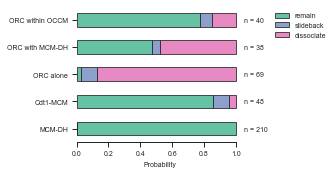

In [27]:
#plot a stacked barplot
fig,axes = plt.subplots(figsize=(3,2.5))

(df_stab/df_stab.sum()).T.plot(kind='barh',stacked=True,ax=axes,rot=0,edgecolor='.15',
                               color=[palettes['qualitative'][0],palettes['qualitative'][2],
                                      palettes['qualitative'][3]])

axes.set_xlabel("Probability")

#axes.set_title("Fate upon T7RNAP-MCM collision")
axes.set_xlim([0,1.05])
#axes.set_yticks([])

labels = [int(df_stab.sum()[col]) for col in df_stab.columns]

#calculate y offset to label bars on top

rects = axes.patches
counter = 0
for rect, label in zip(rects, labels):
    axes.text(1.05, rect.get_y() + rect.get_height()/2, s=f'n = {label}', ha='left', va='center')
    counter+=1
axes.legend(ncol=1,bbox_to_anchor=[1.15, 1], loc='upper left',frameon=False)

#tidy up
#fig.tight_layout()
sns.despine(trim=True,left=True)

#save
plt.savefig(dir_out+'6H_MCM-ORC_T7T_stability.svg',transparent=True)

### Figure S6E: ORC stability with MCM DHs with MCM intensities

In [28]:
df_orc_stab.head()

,orc_state,t7t_outcome,mcm_intensity,variance (kbp^2),msd (kbp^2),dtime (s),d_coeff (kbp^2/s)
0,ORC alone,remain,0.0,0.092735,0.022223,5.243117,0.002119
0,ORC alone,slideback,0.0,21.022535,1.736975,5.180000,0.167662
0,ORC alone,dissociate,0.0,0.000000,1.736975,5.180000,0.167662
0,ORC alone,dissociate,0.0,0.000000,1.736975,5.180000,0.167662
0,ORC alone,dissociate,0.0,0.000000,1.736975,5.180000,0.167662


In [29]:
# reject one molecule with high mcm intensity
df_orc_stab[df_orc_stab['mcm_intensity'] > 200000]

,orc_state,t7t_outcome,mcm_intensity,variance (kbp^2),msd (kbp^2),dtime (s),d_coeff (kbp^2/s)
0,ORC with MCM-DH,dissociate,382980.55,0.0,0.013582,6.593348,0.00103


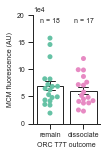

In [30]:
fig,axes = plt.subplots(figsize=(1.2, 2))

sns.swarmplot(x='t7t_outcome', y='mcm_intensity', 
              data=df_orc_stab[(df_orc_stab['orc_state']=='ORC with MCM-DH') & 
                               (df_orc_stab['t7t_outcome']!='slideback') & 
                               (df_orc_stab['mcm_intensity'] < 200000)], 
              palette=[palettes['qualitative'][0],palettes['qualitative'][3]], ax=axes)
                       
sns.barplot(x='t7t_outcome', y='mcm_intensity', 
              data=df_orc_stab[(df_orc_stab['orc_state']=='ORC with MCM-DH') & 
                               (df_orc_stab['t7t_outcome']!='slideback') & 
                               (df_orc_stab['mcm_intensity'] < 200000)], 
            palette=[palettes['qualitative'][0],palettes['qualitative'][3]], facecolor=(1, 1, 1, 0),
            lw=1, edgecolor='.15', capsize=.3,errwidth=1, ax=axes, 
            n_boot=10000, seed=42, ci=68, errcolor='.15')

axes.set_ylim(0,200000)
axes.set_xlabel('ORC T7T outcome')
axes.set_ylabel('MCM fluorescence (AU)')
plt.ticklabel_format(axis="y", style="sci",scilimits=(4,4))

#calculate number of observations
nobs = df_orc_stab[(df_orc_stab['orc_state']=='ORC with MCM-DH') & 
                               (df_orc_stab['t7t_outcome']!='slideback') & 
                               (df_orc_stab['mcm_intensity'] < 200000)]['t7t_outcome'].value_counts()
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n = " + i for i in nobs]

#put nobs into plot
pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    transform=axes.transAxes, axes.text(pos[tick], 190000, nobs[tick],
    horizontalalignment='center',verticalalignment='center')


    
sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'S6E_ORC-MCM-DH_stability_vs_MCMintensity.svg',transparent=True)
